#### 0. Imports and helper functions

In [1]:
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.layers import Input, Dense, BatchNormalization, LeakyReLU

2024-07-29 15:24:33.419255: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-29 15:24:38.762025: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-29 15:24:52.116518: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import sys
sys.path.append('../../') # Append the path to the root of the project to sys.path

In [4]:
from src.authentication import EcgAuthenticator
from src.modelling.generator.ecg_generator_independent import EcgGeneratorIndependent

In [5]:
with open('../../data/processed/autoencoder_data.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = np.array(data['X_train'])
X_test = np.array(data['X_test'])
X_val = np.array(data['X_val'])
y_test = set(data['y_test'])
y_train = set(data['y_train'])
y_val = set(data['y_val'])

In [6]:
test_user_ids = list(set(y_test))
authenticator = EcgAuthenticator()

2024-07-29 15:25:26.751302: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-29 15:25:26.803181: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/users/pgrad/kanellog/Documents/Dissertation/.venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 28 variables whereas the saved optimizer has 54 variables. 
  saveable.load_

In [7]:
def build_autoencoder(input_shape, latent_space_size, layer_sizes):

    # Encoder
    input_layer = Input(shape=input_shape)
    x = input_layer
    for layer_size in layer_sizes:
        x = Dense(layer_size)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
    latent_space = Dense(latent_space_size)(x)
    encoder = Model(input_layer, latent_space, name='encoder')

    # Decoder
    decoder_input = Input(shape=(latent_space_size,))
    x = decoder_input
    for layer_size in reversed(layer_sizes):
        x = Dense(layer_size)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
    output_layer = Dense(input_shape[0])(x)
    decoder = Model(decoder_input, output_layer, name='decoder')

    # Autoencoder
    autoencoder = Model(input_layer, decoder(encoder(input_layer)))

    return autoencoder

In [8]:
def calculate_accuracy_confidence_interval(y_pred, y_true, n_samples=1000, sample_size=500):
    observation_arr = []
    for _ in range(n_samples):
        idx = np.random.choice(len(y_pred), sample_size, replace=True)
        y_pred_sample = [y_pred[i] for i in idx]
        y_true_sample = [y_true[i] for i in idx]
        observation_arr.append(
            np.mean(np.array(y_pred_sample) == np.array(y_true_sample))
        )
    ci_lower, ci_upper, mean = np.percentile(observation_arr, [2.5, 97.5, 50])
    return ci_lower, ci_upper, mean

#### 1. Optimise latent space size

In [9]:
latent_space_sizes = [4, 8, 16, 25, 32, 64, 128]

In [11]:
with open('../../experiments/loss_vs_latent_space_size.pkl', 'rb') as f:
    history_arr = pickle.load(f)

In [12]:
# history_arr = []
for latent_space_size in [25]:
    autoencoder = build_autoencoder(
        input_shape=(600,), 
        latent_space_size=latent_space_size, 
        layer_sizes=[256, 128]
    )
    optimizer = Adam(learning_rate=0.0001)
    autoencoder.compile(optimizer=optimizer, loss='mse')
    history = autoencoder.fit(
        X_train, X_train, 
        validation_data=(X_val, X_val), 
        epochs=100, batch_size=64
    )
    history_arr.append({
        'latent_space_size': latent_space_size,
        'history': history.history
    })
    autoencoder.save(f'../../models/dense/LeakyReLU_BatchNorm_ThreeLayers_{latent_space_size}.keras')

Epoch 1/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0689 - val_loss: 0.0032
Epoch 2/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 3/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 4/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 5/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 6/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 7/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 8/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0011 - val_loss: 7.1752e-04
Epoch 9/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0010 - val_loss: 7.1629e-04
Epoch 10/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 9.6650e-04 - val_loss: 6.7698e-04
Epoch 11/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.3072e-04 - val_loss: 5.5977e-04
Epoch 12/100
908/

In [13]:
with open('../../experiments/loss_vs_latent_space_size.pkl', 'wb') as f:
    pickle.dump(history_arr, f)

##### 1.1. Reconstruction error vs latent space size

In [14]:
reconstruction_errors = []
for lss in latent_space_sizes:
    model = load_model(f'../../models/dense/LeakyReLU_BatchNorm_ThreeLayers_{lss}.keras')
    y_pred = model.predict(X_test)
    reconstruction_error = np.mean(np.square(y_pred - X_test), axis=1)
    reconstruction_errors.append(reconstruction_error)

I0000 00:00:1722266400.420501 1185979 service.cc:145] XLA service 0x5556a60f7c10 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722266400.420524 1185979 service.cc:153]   StreamExecutor device (0): Host, Default Version
2024-07-29 16:20:00.984493: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


267/607 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step

I0000 00:00:1722266402.615626 1185979 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


607/607 ━━━━━━━━━━━━━━━━━━━━ 3s 725us/step
607/607 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step
607/607 ━━━━━━━━━━━━━━━━━━━━ 1s 731us/step
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
607/607 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step
607/607 ━━━━━━━━━━━━━━━━━━━━ 1s 747us/step
607/607 ━━━━━━━━━━━━━━━━━━━━ 1s 708us/step


In [15]:
with open('../../experiments/reconstruction_errors_vs_latent_space_size.pkl', 'wb') as f:
    pickle.dump([latent_space_sizes, reconstruction_errors], f)

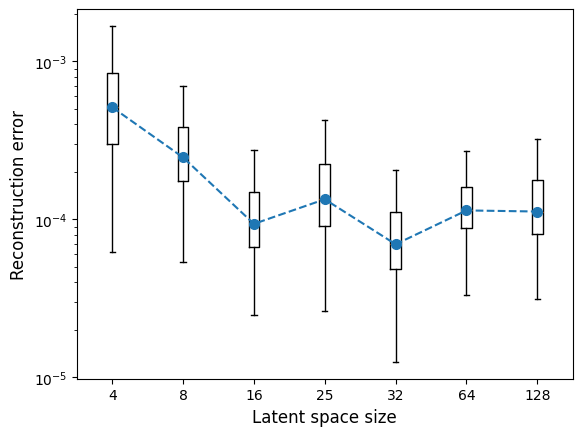

In [17]:
fig, ax = plt.subplots()
medians = []
for i, err in enumerate(reconstruction_errors):
    bp = ax.boxplot(err, positions=[i], showfliers=False, bootstrap=1000)
    medians.append(
        bp['medians'][0].get_ydata()[0]
    )
ax.plot(range(len(reconstruction_errors)), medians, '--o', zorder=10, markersize=7)
ax.set_xticks(range(len(reconstruction_errors)))
ax.set_xticklabels(latent_space_sizes)
ax.set_xlabel('Latent space size', fontsize=12)
ax.set_ylabel('Reconstruction error', fontsize=12)
ax.semilogy()

# fig.savefig('../../figures/model_architecture/reconstruction_error_vs_latent_space_size.pdf', bbox_inches='tight')
plt.show()

##### 1.2. Authenticator accuracy vs latency space size

In [18]:
with open('../../experiments/y_pred_vs_latent_space_size.pkl', 'rb') as f:
    pred_arr = pickle.load(f)

In [19]:
# pred_arr = []
for latent_dim in [25]:
    generator = EcgGeneratorIndependent(
        model_path=f'../../models/dense/LeakyReLU_BatchNorm_ThreeLayers_{latent_dim}.keras',
        n_samples=30
    )
    y_true, y_pred = [], []
    print(f'Testing latent space size {latent_dim}...')
    pbar = tqdm(total=len(test_user_ids))
    for user_id in test_user_ids:
        try:
            synthetic_templates = generator.generate_synthetic_signals(user_id)
            if synthetic_templates is not None:
                pred_user_id = authenticator.identify(synthetic_templates, majority_votes=10)
                y_true.extend([user_id]*len(pred_user_id))
                y_pred.extend(pred_user_id)
        except Exception as e:
            print(f'Error processing user {user_id}: {e}')
        finally:
            pbar.update(1)
    pbar.close()
    pred_arr.append({
        'latent_dim': latent_dim,
        'y_true': y_true,
        'y_pred': y_pred
    })

Testing latent space size 25...


  0%|          | 0/194 [00:00<?, ?it/s]

100%|██████████| 194/194 [02:37<00:00,  1.23it/s]


In [22]:
pred_arr = sorted(pred_arr, key=lambda x: x['latent_dim'])

In [23]:
with open('../../experiments/y_pred_vs_latent_space_size.pkl', 'wb') as f:
    pickle.dump(pred_arr, f)

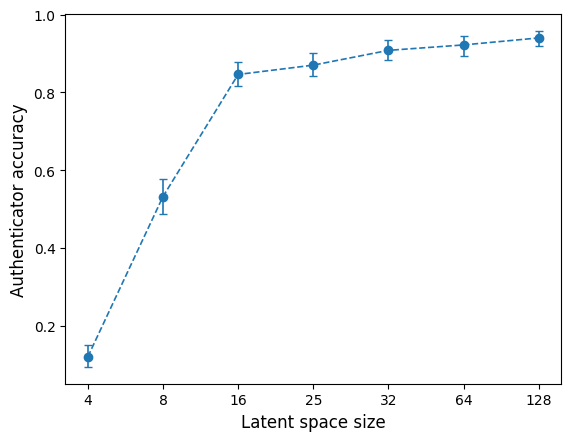

In [24]:
fig, ax = plt.subplots()

accuracy_arr = []
for i, err in enumerate(pred_arr):
    y_true = err['y_true']
    y_pred = err['y_pred']
    accuracy_arr.append(
        calculate_accuracy_confidence_interval(y_pred, y_true)
    )

x_arr = range(len(pred_arr))
y_arr = [acc[2] for acc in accuracy_arr]
y_err = [(acc[2] - acc[0], acc[1] - acc[2]) for acc in accuracy_arr]
ax.errorbar(x_arr, y_arr, yerr=np.array(y_err).T, fmt='--o', label='Accuracy', linewidth=1.2, capsize=3)

ax.set_xticks(x_arr)
ax.set_xticklabels([pred['latent_dim'] for pred in pred_arr])
ax.set_xlabel('Latent space size', fontsize=12)
ax.set_ylabel('Authenticator accuracy', fontsize=12)

# fig.savefig('../../figures/model_architecture/accuracy_vs_latent_space_size.pdf', bbox_inches='tight')
plt.show()

##### 1.3. Combine reconstruction error and accuracy in a plot

In [25]:
with open('../../experiments/y_pred_vs_latent_space_size.pkl', 'rb') as f:
    pred_arr = pickle.load(f)

In [26]:
with open('../../experiments/reconstruction_errors_vs_latent_space_size.pkl', 'rb') as f:
    latent_space_sizes, reconstruction_errors = pickle.load(f)

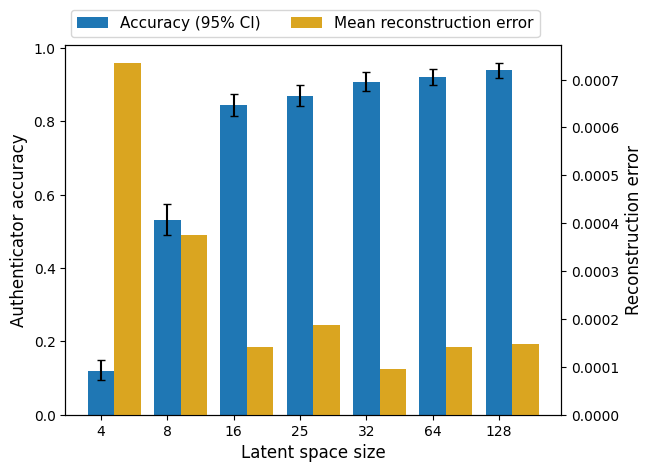

In [29]:
fig, ax = plt.subplots()

accuracy_arr = []
for i, err in enumerate(pred_arr):
    y_true = err['y_true']
    y_pred = err['y_pred']
    accuracy_arr.append(
        calculate_accuracy_confidence_interval(y_pred, y_true)
    )

x_arr = range(len(pred_arr))
y_arr = [acc[2] for acc in accuracy_arr]
y_err = [(acc[2] - acc[0], acc[1] - acc[2]) for acc in accuracy_arr]
ax.bar(x_arr, y_arr, yerr=np.array(y_err).T, label='Accuracy (95% CI)', color='tab:blue', width=0.4, linewidth=1.2, capsize=3)
# ax.errorbar(x_arr, y_arr, yerr=np.array(y_err).T, fmt='--o', label='Accuracy', linewidth=1.2, capsize=3)

tw_ax = ax.twinx()
for i, err in enumerate(reconstruction_errors):
    mean_err, q1, q3 = np.mean(err), np.percentile(err, 25), np.percentile(err, 75)
    y_err = [(mean_err - q1, q3 - mean_err)]
    if i == 0:
        tw_ax.bar(i+0.4, mean_err, width=0.4, color='goldenrod', label='Mean reconstruction error')
    else:
        tw_ax.bar(i+0.4, mean_err, width=0.4, color='goldenrod') #, yerr=np.array(y_err).T, linewidth=1.2, capsize=3)
tw_ax.set_ylabel('Reconstruction error', fontsize=12)

ax.set_xticks(x_arr)
ax.set_xticklabels([pred['latent_dim'] for pred in pred_arr])
ax.set_xlabel('Latent space size', fontsize=12)
ax.set_ylabel('Authenticator accuracy', fontsize=12)

fig.legend(ncols=2, loc='upper center', fontsize=11, bbox_to_anchor=(0.5, 0.97))

fig.savefig('../../figures/model_architecture/accuracy_vs_latent_space_size.pdf', bbox_inches='tight', transparent=True)
plt.show()

#### 2. Optimise number of layers

In [78]:
layer_sizes = [
    [512],
    [512, 256],
    [512, 256, 128],
    [512, 256, 128, 64],
    [256],
    [256, 128],
    [256, 128, 64],
    [128],
    [128, 64],
    [64]
]

In [85]:
history_arr = []
for ls in layer_sizes:
    autoencoder = build_autoencoder(
        input_shape=(600,), 
        latent_space_size=32, 
        layer_sizes=ls
    )
    optimizer = Adam(learning_rate=0.0001)
    autoencoder.compile(optimizer=optimizer, loss='mse')
    history = autoencoder.fit(
        X_train, X_train, 
        validation_data=(X_val, X_val), 
        epochs=100, batch_size=64
    )
    label = '-'.join(map(str, ls))
    history_arr.append({
        'layer_sizes': ls,
        'layer_sizes_label': label,
        'history': history.history
    })
    autoencoder.save(f'../../models/dense/LeakyReLU_BatchNorm_Latent32_{label}.keras')

Epoch 1/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0601 - val_loss: 0.0036
Epoch 2/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 864us/step - loss: 0.0029 - val_loss: 0.0022
Epoch 3/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 877us/step - loss: 0.0023 - val_loss: 0.0020
Epoch 4/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 891us/step - loss: 0.0019 - val_loss: 0.0012
Epoch 5/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 6/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 933us/step - loss: 0.0015 - val_loss: 0.0010
Epoch 7/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 871us/step - loss: 0.0013 - val_loss: 8.8174e-04
Epoch 8/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 861us/step - loss: 0.0012 - val_loss: 9.0766e-04
Epoch 9/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 889us/step - loss: 0.0012 - val_loss: 7.7841e-04
Epoch 10/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 866us/step - loss: 0.0011 - val_loss: 8.6139e-04
Epoch 11/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 864us/step - loss: 0.0010 - val_loss: 6.7163e-04
E

In [86]:
with open('../../experiments/loss_vs_layer_sizes.pkl', 'wb') as f:
    pickle.dump(history_arr, f)

##### 2.1. Reconstruction error vs layer size

In [10]:
reconstruction_errors = []
for ls in layer_sizes:
    label = '-'.join(map(str, ls))
    model = load_model(f'../../models/dense/LeakyReLU_BatchNorm_Latent32_{label}.keras')
    y_pred = model.predict(X_test)
    reconstruction_error = np.mean(np.square(y_pred - X_test), axis=1)
    reconstruction_errors.append(reconstruction_error)

I0000 00:00:1721645815.209176  887921 service.cc:145] XLA service 0x7f4cc00091e0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721645815.209195  887921 service.cc:153]   StreamExecutor device (0): Host, Default Version
2024-07-22 11:56:55.212558: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  1/607 ━━━━━━━━━━━━━━━━━━━━ 11:24 1s/step

I0000 00:00:1721645816.062612  887921 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


607/607 ━━━━━━━━━━━━━━━━━━━━ 2s 829us/step
607/607 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
607/607 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
607/607 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step
607/607 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step
607/607 ━━━━━━━━━━━━━━━━━━━━ 1s 811us/step
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step


In [11]:
with open('../../experiments/reconstruction_errors_vs_layer_sizes.pkl', 'wb') as f:
    pickle.dump([layer_sizes, reconstruction_errors], f)

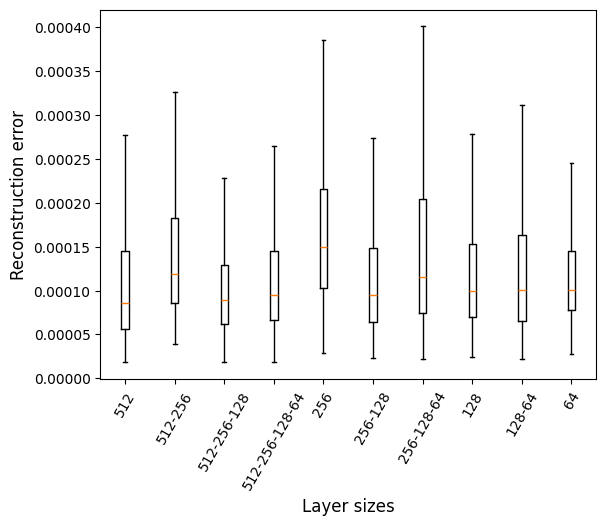

In [91]:
fig, ax = plt.subplots()
for i, err in enumerate(reconstruction_errors):
    bp = ax.boxplot(err, positions=[i], showfliers=False, bootstrap=1000)
ax.set_xticks(range(len(reconstruction_errors)))
ax.set_xticklabels(['-'.join(map(str, ls)) for ls in layer_sizes], rotation=60)
ax.set_xlabel('Layer sizes', fontsize=12)
ax.set_ylabel('Reconstruction error', fontsize=12)
# ax.semilogy()

fig.savefig('../../figures/model_architecture/reconstruction_error_vs_layer_sizes.pdf', bbox_inches='tight')
plt.show()

In [83]:
autoencoder.get_layer('encoder').summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 64)             │        38,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_42 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 32)             │         2,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,800 (159.38 KB)

 Trainable params: 40,672 (158.88 KB)

 Non-trainable params: 128 (512.00 B)

##### 2.2. Authenticator accuracy vs layer count

In [92]:
pred_arr = []
for ls in layer_sizes:
    label = '-'.join(map(str, ls))
    generator = EcgGeneratorIndependent(
        model_path=f'../../models/dense/LeakyReLU_BatchNorm_Latent32_{label}.keras',
        n_samples=30
    )
    y_true, y_pred = [], []
    print(f'Testing model with layer label {label}...')
    pbar = tqdm(total=len(test_user_ids))
    for user_id in test_user_ids:
        try:
            synthetic_templates = generator.generate_synthetic_signals(user_id)
            if synthetic_templates is not None:
                pred_user_id = authenticator.identify(synthetic_templates, majority_votes=10)
                y_true.extend([user_id]*len(pred_user_id))
                y_pred.extend(pred_user_id)
        except Exception as e:
            print(f'Error processing user {user_id}: {e}')
        finally:
            pbar.update(1)
    pbar.close()
    pred_arr.append({
        'layer_size_label': label,
        'y_true': y_true,
        'y_pred': y_pred
    })

Testing model with layer label 512...


100%|██████████| 194/194 [02:36<00:00,  1.24it/s]


Testing model with layer label 512-256...


100%|██████████| 194/194 [02:28<00:00,  1.31it/s]


Testing model with layer label 512-256-128...


100%|██████████| 194/194 [02:39<00:00,  1.22it/s]


Testing model with layer label 512-256-128-64...


100%|██████████| 194/194 [02:34<00:00,  1.25it/s]


Testing model with layer label 256...


100%|██████████| 194/194 [02:41<00:00,  1.20it/s]


Testing model with layer label 256-128...


100%|██████████| 194/194 [02:29<00:00,  1.30it/s]


Testing model with layer label 256-128-64...


100%|██████████| 194/194 [02:34<00:00,  1.26it/s]


Testing model with layer label 128...


100%|██████████| 194/194 [02:34<00:00,  1.26it/s]


Testing model with layer label 128-64...


100%|██████████| 194/194 [02:39<00:00,  1.22it/s]


Testing model with layer label 64...


100%|██████████| 194/194 [02:47<00:00,  1.16it/s]


In [93]:
with open('../../experiments/y_pred_vs_layer_sizes.pkl', 'wb') as f:
    pickle.dump(pred_arr, f)

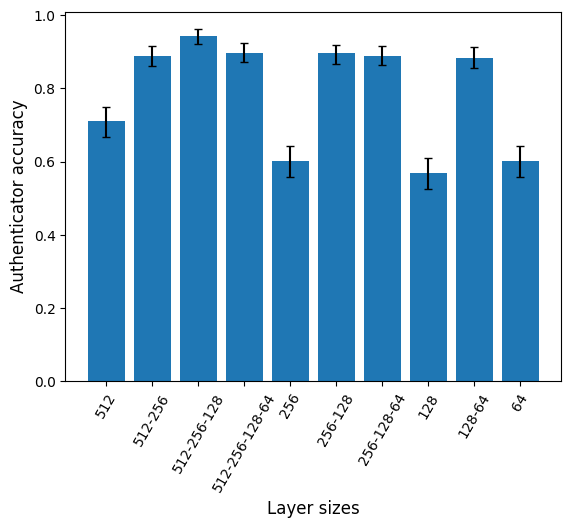

In [95]:
fig, ax = plt.subplots()

accuracy_arr = []
for i, err in enumerate(pred_arr):
    y_true = err['y_true']
    y_pred = err['y_pred']
    accuracy_arr.append(
        calculate_accuracy_confidence_interval(y_pred, y_true)
    )

x_arr = range(len(pred_arr))
y_arr = [acc[2] for acc in accuracy_arr]
y_err = [(acc[2] - acc[0], acc[1] - acc[2]) for acc in accuracy_arr]
ax.bar(x_arr, y_arr, yerr=np.array(y_err).T, linewidth=1.2, capsize=3)
# ax.errorbar(x_arr, y_arr, yerr=np.array(y_err).T, fmt='--o', label='Accuracy', linewidth=1.2, capsize=3)

ax.set_xticks(x_arr)
ax.set_xticklabels([pred['layer_size_label'] for pred in pred_arr], rotation=60)
ax.set_xlabel('Layer sizes', fontsize=12)
ax.set_ylabel('Authenticator accuracy', fontsize=12)

fig.savefig('../../figures/model_architecture/accuracy_vs_layer_size.pdf', bbox_inches='tight')
plt.show()

##### 2.3. Combine reconstruction error and accuracy in a plot

In [30]:
with open('../../experiments/y_pred_vs_layer_sizes.pkl', 'rb') as f:
    pred_arr = pickle.load(f)

In [31]:
with open('../../experiments/reconstruction_errors_vs_layer_sizes.pkl', 'rb') as f:
    layer_sizes, reconstruction_errors = pickle.load(f)

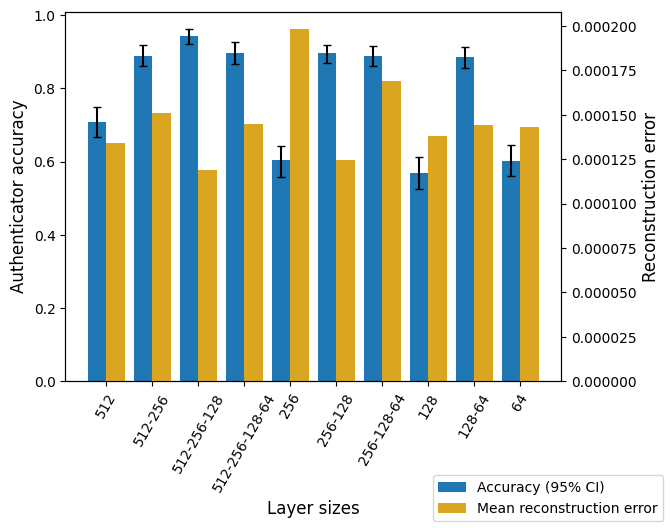

In [32]:
fig, ax = plt.subplots()

accuracy_arr = []
for i, err in enumerate(pred_arr):
    y_true = err['y_true']
    y_pred = err['y_pred']
    accuracy_arr.append(
        calculate_accuracy_confidence_interval(y_pred, y_true)
    )

x_arr = np.arange(len(pred_arr))
y_arr = [acc[2] for acc in accuracy_arr]
y_err = [(acc[2] - acc[0], acc[1] - acc[2]) for acc in accuracy_arr]
ax.bar(x_arr, y_arr, width=0.4, yerr=np.array(y_err).T, linewidth=1.2, capsize=3, label='Accuracy (95% CI)', color='tab:blue')

tw_ax = ax.twinx()
for i, err in enumerate(reconstruction_errors):
    mean_err = np.mean(err)
    if i == 0:
        tw_ax.bar(i+0.4, mean_err, width=0.4, color='goldenrod', label='Mean reconstruction error')
    else:
        tw_ax.bar(i+0.4, mean_err, width=0.4, color='goldenrod')
tw_ax.set_ylabel('Reconstruction error', fontsize=12)

ax.set_xticks(x_arr+0.2)
ax.set_xticklabels([pred['layer_size_label'] for pred in pred_arr], rotation=60)
ax.set_xlabel('Layer sizes', fontsize=12)
ax.set_ylabel('Authenticator accuracy', fontsize=12)

fig.legend(loc='lower right')

fig.savefig('../../figures/model_architecture/accuracy_vs_reconstruction_error_vs_layer_size.pdf', bbox_inches='tight', transparent=True)
plt.show()

#### Old code

In [ ]:
optimizer = Adam(learning_rate=0.0001)
autoencoder.train_model(x_train=X_train, x_val=X_val, optimizer=optimizer, max_epochs=500, batch_size=64)

Epoch 1/500


I0000 00:00:1720444119.231601 1825399 service.cc:145] XLA service 0x7f79e8001640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720444119.231621 1825399 service.cc:153]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2024-07-08 14:08:39.265852: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-08 14:08:39.414954: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


164/908 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 0.0848

I0000 00:00:1720444120.000899 1825399 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


908/908 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0355 - val_loss: 0.0018
Epoch 2/500
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 3/500
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 4/500
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.8840e-04 - val_loss: 7.4497e-04
Epoch 5/500
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.5427e-04 - val_loss: 6.2065e-04
Epoch 6/500
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.0783e-04 - val_loss: 7.3303e-04
Epoch 7/500
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.7205e-04 - val_loss: 7.8275e-04
Epoch 8/500
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.1162e-04 - val_loss: 6.0249e-04
Epoch 9/500
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.7457e-04 - val_loss: 7.7321e-04
Epoch 10/500
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.7255e-04 - val_loss: 5.4648e-04
Epoch 11/500
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.4206e-04 - val_loss: 

In [37]:
from autoencoder_models.two_dense_layers import TwoDenseLayersAutoencoder

In [39]:
autoencoder = TwoDenseLayersAutoencoder(input_dim=600, latent_dim=64)
autoencoder.build_model()

TypeError: TwoDenseLayersAutoencoder.__init__() missing 1 required positional argument: 'model_name'

In [44]:
for latent_space_size in [4]: #, 8, 16, 24, 32, 64, 128]:
    optimizer = Adam(learning_rate=0.0001)
    autoencoder = TwoDenseLayersAutoencoder(
        input_dim=600, 
        latent_dim=latent_space_size, 
        model_name = f'LeakyReLU_BatchNorm_TwoLayers_{latent_space_size}'
    )
    autoencoder.build_model()
    autoencoder.train_model(
        x_train=X_train, x_val=X_val, 
        optimizer=optimizer, 
        max_epochs=500, batch_size=64
    )

Epoch 1/500
908/908 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0371 - val_loss: 0.0024
Epoch 2/500
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 3/500
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 4/500
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 5/500
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 6/500
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 7/500
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 8/500
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 9/500
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 10/500
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 11/500
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 12/500
908/908 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
from keras.models import load_model

In [40]:
def calculate_mse_confidence_interval(y_pred, y_true, n_samples=1000, sample_size=500):
    mse_arr = []
    for _ in range(n_samples):
        idx = np.random.choice(len(y_pred), sample_size, replace=True)
        y_pred_sample = np.array([y_pred[i] for i in idx])
        y_true_sample = np.array([y_true[i] for i in idx])
        mse_per_heartbeat = np.mean(np.square(y_pred_sample - y_true_sample), axis=1)
        mse_arr.append(np.mean(mse_per_heartbeat))

    ci_lower, ci_upper, mean = np.percentile(mse_arr, [2.5, 97.5, 50])
    return mean, ci_lower, ci_upper

In [ ]:
import matplotlib.pyplot as plt

In [77]:
mse_arr = []
for latent_space_size in [8, 16, 32, 64, 128]:
    autoencoder = load_model(f'autoencoder_models/trained_models/LeakyReLU_BatchNorm_TwoLayers_{latent_space_size}.keras')
    y_pred = autoencoder.predict(X_test)
    mean_mse, lower, upper = calculate_mse_confidence_interval(y_pred, X_test)
    mse_arr.append({
        'latent_space_size': latent_space_size,
        'mean_mse': mean_mse,
        'ci_lower': lower,
        'ci_upper': upper
    })

607/607 ━━━━━━━━━━━━━━━━━━━━ 1s 723us/step
607/607 ━━━━━━━━━━━━━━━━━━━━ 1s 682us/step
607/607 ━━━━━━━━━━━━━━━━━━━━ 1s 638us/step
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step
607/607 ━━━━━━━━━━━━━━━━━━━━ 1s 679us/step


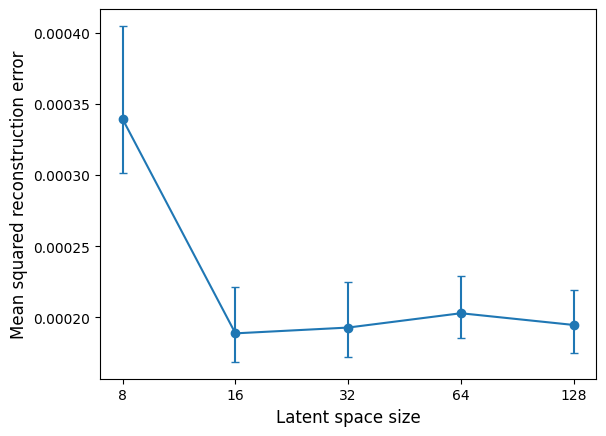

In [79]:
fig, ax = plt.subplots()
mean_mse = np.array([x['mean_mse'] for x in mse_arr])
ci_lower = np.array([x['ci_lower'] for x in mse_arr])
ci_upper = np.array([x['ci_upper'] for x in mse_arr])
latent_space_size = [x['latent_space_size'] for x in mse_arr]
ax.errorbar(range(len(mse_arr)), mean_mse, yerr=[mean_mse - ci_lower, ci_upper - mean_mse], fmt='o-', capsize=3)
ax.set_xticks(range(len(mse_arr)))
ax.set_xticklabels(latent_space_size)
# ax.semilogy()
ax.set_xlabel('Latent space size', fontsize=12)
ax.set_ylabel('Mean squared reconstruction error', fontsize=12)
fig.savefig('figures/latent_space_size_vs_mse.pdf', bbox_inches='tight')
plt.show()

In [54]:
from utils.ecg_auth import EcgAuthenticator

In [55]:
authenticator = EcgAuthenticator()

/users/pgrad/kanellog/Documents/Dissertation/.venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 28 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [56]:
y_pred_auth = authenticator.identify(y_pred)

In [64]:
y_true = np.array(data['y_test'])

In [65]:
def calculate_accuracy_confidence_interval(y_pred, y_true, n_samples=1000, sample_size=500):
    accuracy_arr = []
    for _ in range(n_samples):
        idx = np.random.choice(len(y_pred), sample_size, replace=True)
        y_pred_sample = np.array([y_pred[i] for i in idx])
        y_true_sample = np.array([y_true[i] for i in idx])
        accuracy = np.mean(y_pred_sample == y_true_sample)
        accuracy_arr.append(accuracy)

    ci_lower, ci_upper, mean = np.percentile(accuracy_arr, [2.5, 97.5, 50])
    return mean, ci_lower, ci_upper

In [73]:
val_arr = []
y_true = np.array(data['y_test'])
for latent_space_size in [8, 16, 32, 64, 128]:
    autoencoder = load_model(f'autoencoder_models/trained_models/LeakyReLU_BatchNorm_TwoLayers_{latent_space_size}.keras')
    y_pred = autoencoder.predict(X_test)
    y_pred_auth = authenticator.identify(y_pred)
    mean, lower, upper = calculate_accuracy_confidence_interval(y_pred_auth, y_true)
    val_arr.append({
        'latent_space_size': latent_space_size,
        'mean': mean,
        'ci_lower': lower,
        'ci_upper': upper
    })

607/607 ━━━━━━━━━━━━━━━━━━━━ 1s 646us/step
607/607 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step
607/607 ━━━━━━━━━━━━━━━━━━━━ 1s 662us/step
607/607 ━━━━━━━━━━━━━━━━━━━━ 1s 645us/step
607/607 ━━━━━━━━━━━━━━━━━━━━ 1s 637us/step


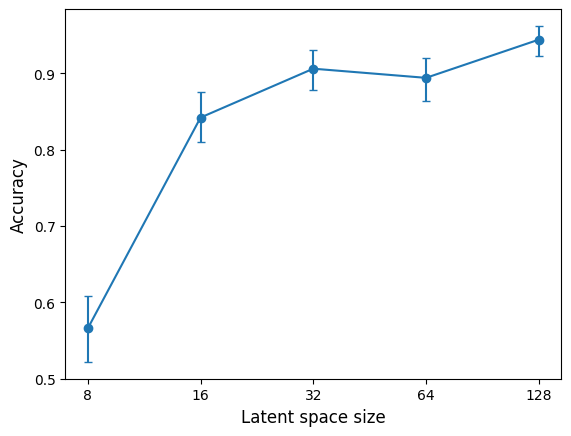

In [81]:
fig, ax = plt.subplots()
mean = np.array([x['mean'] for x in val_arr])
ci_lower = np.array([x['ci_lower'] for x in val_arr])
ci_upper = np.array([x['ci_upper'] for x in val_arr])
latent_space_size = [x['latent_space_size'] for x in val_arr]
ax.errorbar(range(len(val_arr)), mean, yerr=[mean - ci_lower, ci_upper - mean], fmt='o-', capsize=3)
ax.set_xticks(range(len(val_arr)))
ax.set_xticklabels(latent_space_size)
# ax.semilogy()
ax.set_xlabel('Latent space size', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
fig.savefig('figures/latent_space_size_vs_accuracy.pdf', bbox_inches='tight')
plt.show()

In [80]:
val_arr

[{'latent_space_size': 8, 'mean': 0.566, 'ci_lower': 0.522, 'ci_upper': 0.608},
 {'latent_space_size': 16, 'mean': 0.842, 'ci_lower': 0.81, 'ci_upper': 0.876},
 {'latent_space_size': 32, 'mean': 0.906, 'ci_lower': 0.878, 'ci_upper': 0.93},
 {'latent_space_size': 64, 'mean': 0.894, 'ci_lower': 0.864, 'ci_upper': 0.92},
 {'latent_space_size': 128,
  'mean': 0.944,
  'ci_lower': 0.922,
  'ci_upper': 0.962}]